In [26]:
pip install tensorflow_addons

In [25]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pip in d:\anaconda\lib\site-packages (22.3.1)
     ---------------------------------------- 2.1/2.1 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1



In [97]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [71]:
pip install keras

In [101]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [108]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2
DATA_FOLDER = "C:/Users/ADMIN/Desktop/Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
from keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow_addons as tfa
import tensorflow as tf
%matplotlib inline 
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import SVG

In [75]:
data_df = pd.read_excel(open("data.xlsx", 'rb'), sheet_name='Sheet1')  

In [76]:
data_df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [77]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

In [78]:
print(data_df.loc[(data_df.cataract==1)].shape)
print(data_df.loc[data_df.cataract==0].shape)

(212, 15)
(3288, 15)


In [79]:
data_df.loc[(data_df.cataract==1)]['left_diagnosys'].value_counts()

cataract                                                                   135
normal fundus                                                               24
cataract，lens dust                                                           8
moderate non proliferative retinopathy                                       6
lens dust，cataract                                                           5
mild nonproliferative retinopathy                                            5
lens dust，normal fundus                                                      4
cataract，moderate non proliferative retinopathy                              3
refractive media opacity                                                     3
normal fundus，lens dust                                                      3
severe proliferative diabetic retinopathy                                    2
cataract，mild nonproliferative retinopathy                                   2
drusen，cataract，lens dust                           

In [80]:
data_df.loc[(data_df.cataract==1)]['right_diagnosys'].value_counts()


cataract                                                                  127
normal fundus                                                              24
moderate non proliferative retinopathy                                      9
cataract，lens dust                                                          6
drusen                                                                      5
lens dust，cataract                                                          5
mild nonproliferative retinopathy                                           4
refractive media opacity                                                    4
macular epiretinal membrane                                                 3
epiretinal membrane                                                         3
cataract，moderate non proliferative retinopathy                             3
moderate non proliferative retinopathy，cataract                             3
hypertensive retinopathy，cataract                               

In [81]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [82]:
data_df['le_cataract'] = data_df['left_diagnosys'].apply(lambda x: has_cataract_mentioned(x))
data_df['re_cataract'] = data_df['right_diagnosys'].apply(lambda x: has_cataract_mentioned(x))

In [83]:
cataract_le_list = data_df.loc[(data_df.cataract==1) & (data_df.le_cataract==1)]['left_fundus'].values
cataract_re_list = data_df.loc[(data_df.cataract==1) & (data_df.re_cataract==1)]['right_fundus'].values
print(len(cataract_le_list), len(cataract_re_list))
non_cataract_le_list = data_df.loc[(data_df.cataract==0) & (data_df.left_diagnosys=="normal fundus")]['left_fundus'].sample(150, random_state=314).values
non_cataract_re_list = data_df.loc[(data_df.cataract==0) & (data_df.right_diagnosys=="normal fundus")]['right_fundus'].sample(150, random_state=314).values
print(len(non_cataract_le_list), len(non_cataract_re_list))

159 154
150 150


In [84]:
cataract_list = np.concatenate((cataract_le_list, cataract_re_list), axis = 0)
non_cataract_list = np.concatenate((non_cataract_le_list, non_cataract_re_list), axis = 0)
print(len(non_cataract_list), len(cataract_list))

300 313


In [85]:
print(len(os.listdir(DATA_FOLDER)))

7000


In [86]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list, DATA_FOLDER, is_cataract):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        label = label_image(is_cataract)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [87]:
cat_df = process_data(cataract_list, DATA_FOLDER, 1)

100%|██████████| 313/313 [00:14<00:00, 21.58it/s]


In [88]:
cat_no_df = process_data(non_cataract_list, DATA_FOLDER, 0)

100%|██████████| 300/300 [00:13<00:00, 22.87it/s]


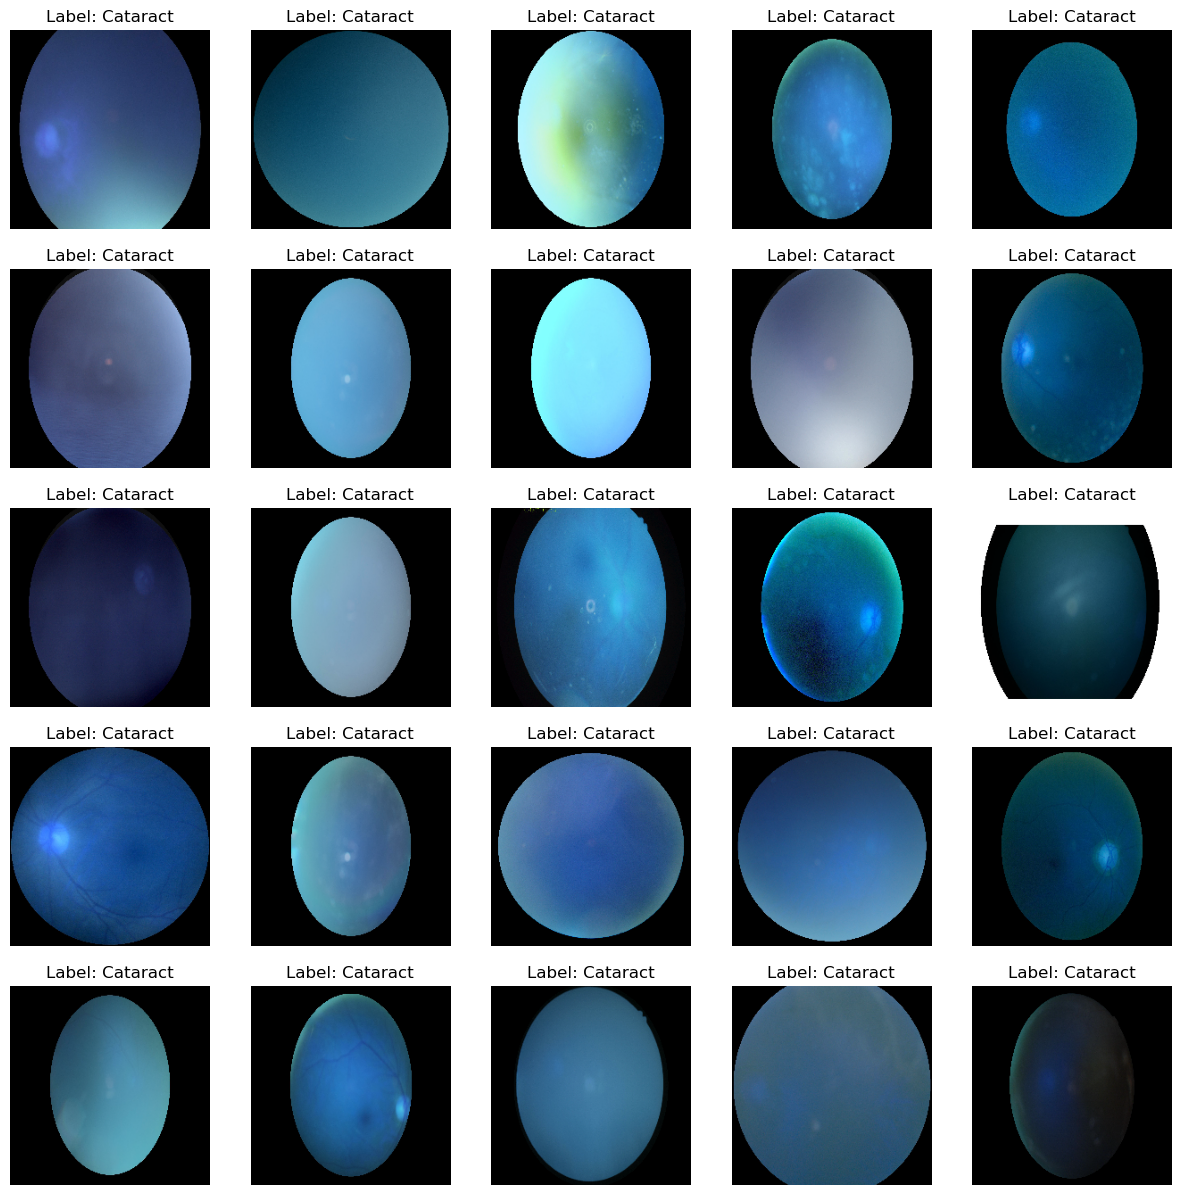

In [89]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 0: 
            str_label='Cataract'
        elif label == 1: 
            str_label='No Cataract'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(cat_df)


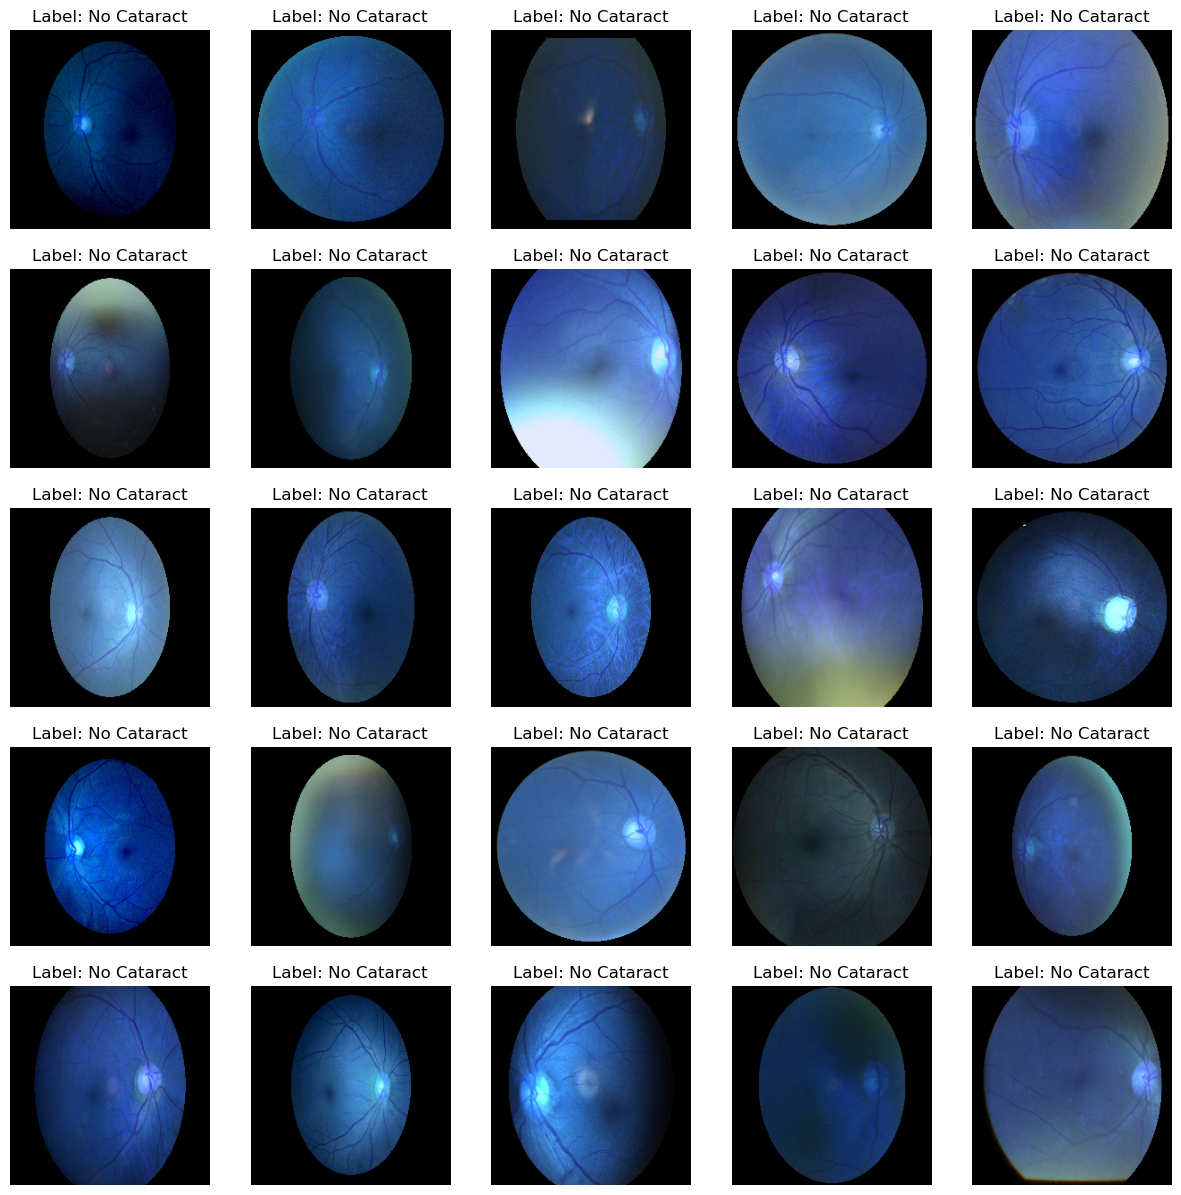

In [90]:
show_images(cat_no_df)

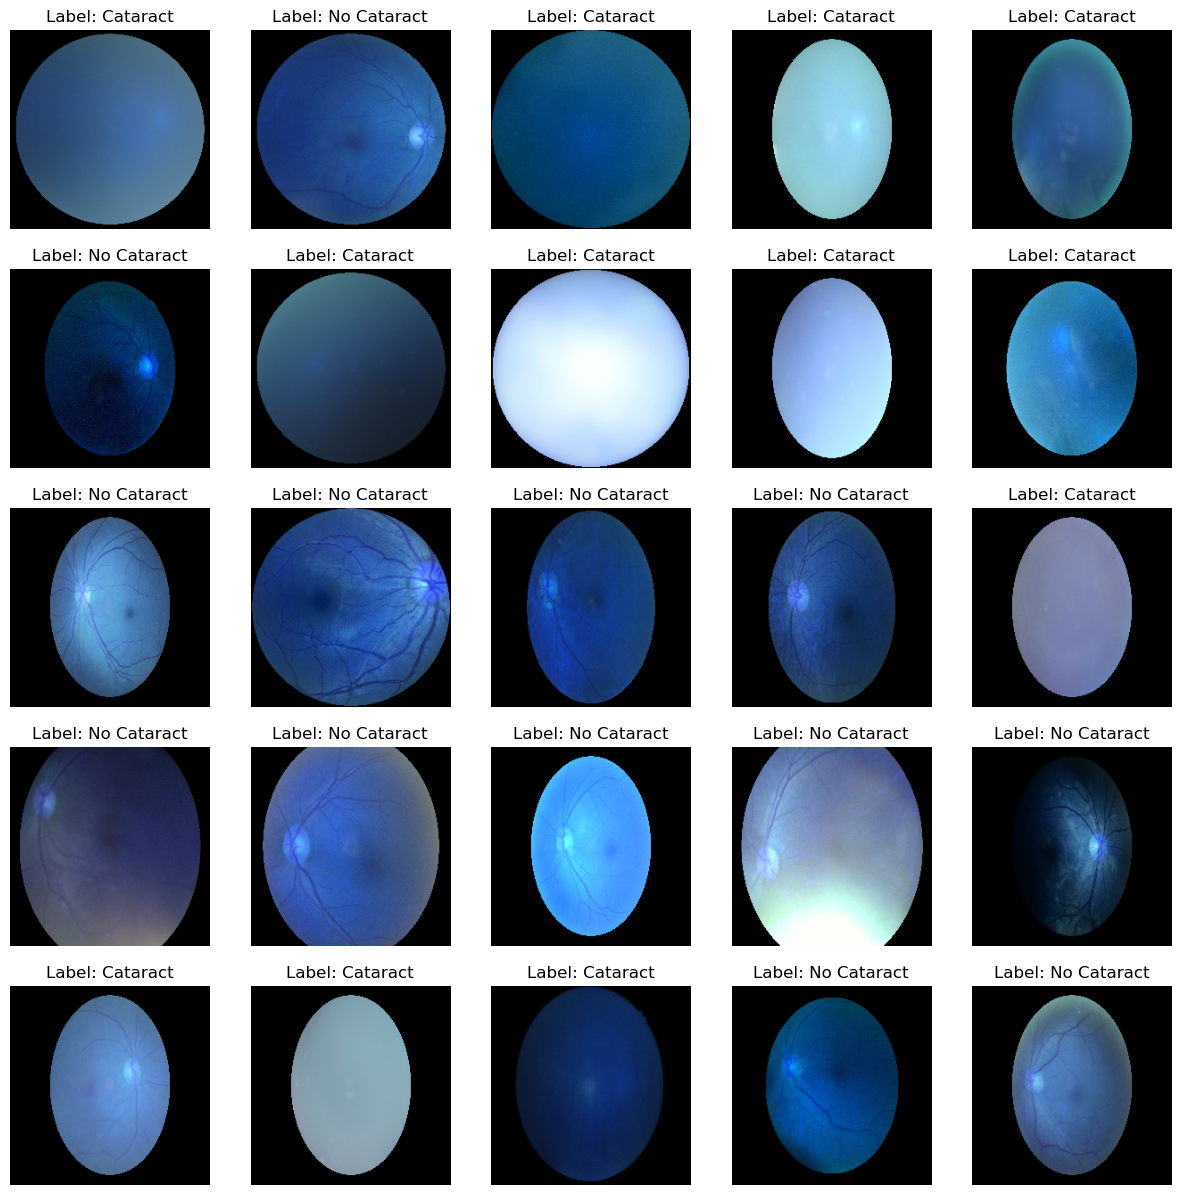

In [91]:
train = cat_df + cat_no_df
shuffle(train)
show_images(train)

In [92]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [93]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True


In [94]:
opt = tfa.optimizers.LazyAdam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2)                4098      
 er)                                                             
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [104]:
pip install pydotplus

     -------------------------------------- 278.7/278.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24554 sha256=54caac75e63a4b23e7cde5e578cd4c84a5b8d0dd2542837484a2a77fbd6d694f
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\89\e5\de\6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [112]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
16/16 [==============================] - 348s 16s/step - loss: 29.7953 - accuracy: 0.5163 - val_loss: 1429893808128.0000 - val_accuracy: 0.4878
Epoch 2/50
 5/16 [========>.....................] - ETA: 8:50 - loss: 16.8530 - accuracy: 0.5125 